In [14]:
import os
batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
import jax
num_cores = jax.local_device_count()
import inference_gym.using_jax as gym


import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns

# Drawing from a sampler

Suppose we want to draw samples from the Banana distribution, using the No-U-Turn Sampler. We proceed as follows:

In [15]:
from sampler_evaluation.models import models
from sampler_evaluation.models.standardgaussian import Gaussian
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error


model=banana()

samples, metadata = samplers['nuts'](return_samples=True)(
        model=gym.targets.Banana(), 
        num_steps=10000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(2,)), 
        key=jax.random.PRNGKey(0))


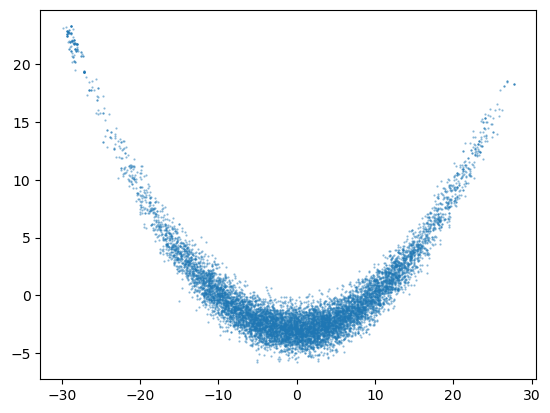

In [3]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)

## Running multiple chains

Often we want to run multiple chains in parallel. In Jax, this can be done as follows:

In [4]:
batch_size = 128

init_keys = jax.random.split(jax.random.key(3), batch_size)

keys = jax.random.split(jax.random.key(3), batch_size)

initial_position = jax.vmap(lambda key: initialize_model(model, key))(init_keys)

num_steps = 20000

samples, metadata = jax.pmap(
        lambda key, pos: samplers['nuts'](return_samples=True)(
        model=model, num_steps=num_steps, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

## Analysing the efficiency of the sampler

To analyse the efficiency of the sampler, we can calculate the *standardized squared error* of $x^2$ and $x$,  respectively defined as:

$\frac{(E_{\mathit{sampler}}[x^2]-E[x^2])^2}{Var[x^2]}$ and $\frac{(E_{\mathit{sampler}}[x]-E[x])^2}{Var[x]}$, where $E_{\mathit{sampler}}$ is the empirical estimate of the expectation. We can then count how many steps of the kernel (and in particular for gradient based samplers, how many gradient calls), it takes for these statistics to drop below a threshold (by default $0.01$). In code:

In [6]:

error_at_each_step = get_standardized_squared_error(
    samples, 
    f=model.sample_transformations["square"],
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2
    )

gradient_calls_per_chain = metadata['num_grads_per_proposal'].mean()

samples_to_low_error(error_at_each_step) * gradient_calls_per_chain

Array(107792.96, dtype=float32)

## Streaming averages, for large models

For models with many parameters (that is, high dimensional distributions), the array of samples, of shape `[batch_size, num_samples, num_dimensions]`, can be too large to fit in memory. However, all we need to keep at each step is a streaming average of the expectations $\mathbb{E}[x]$ and $\mathbb{E}[x^2]$, and return an array of the standarized squared errors at each step, of shape `[num_samples]`.

This is done as follows:

In [7]:
squared_errors, metadata = jax.pmap(
        lambda key, pos: samplers['nuts'](return_samples=False)(
        model=model, num_steps=20000, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

err_t_max_x2 = jnp.median(squared_errors[:, :, 1], axis=0)
samples_to_low_max_x2 = samples_to_low_error(
err_t_max_x2)* metadata["num_grads_per_proposal"].mean()


samples_to_low_max_x2

Array(107792.96, dtype=float32)

## Inspecting benchmark results

This repository provides precalculated results of measuring the efficiency of a range of samplers on a range of models. These results can be viewed as follows:

In [16]:
import itertools
import os
import pandas as pd
from sampler_comparison.samplers import samplers
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
from sampler_evaluation.models.standardgaussian import Gaussian
from sampler_evaluation.models.german_credit import german_credit
from sampler_evaluation.models.stochastic_volatility import stochastic_volatility
from sampler_evaluation.models.item_response import item_response
from sampler_evaluation.models.rosenbrock import Rosenbrock_36D
from sampler_evaluation.models.neals_funnel import neals_funnel


models = {
    "Banana": banana(),
    "Gaussian_100D": Gaussian(ndims=100),
    "Brownian_Motion": brownian_motion(),
    "German_Credit": german_credit(),
    "Rosenbrock_36D": Rosenbrock_36D(),
    # "Neals_Funnel": neals_funnel(),
    # "Stochastic_Volatility": stochastic_volatility(),
    # "Item_Response": item_response(),
}


df = pd.concat([pd.read_csv(os.path.join('..','results', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

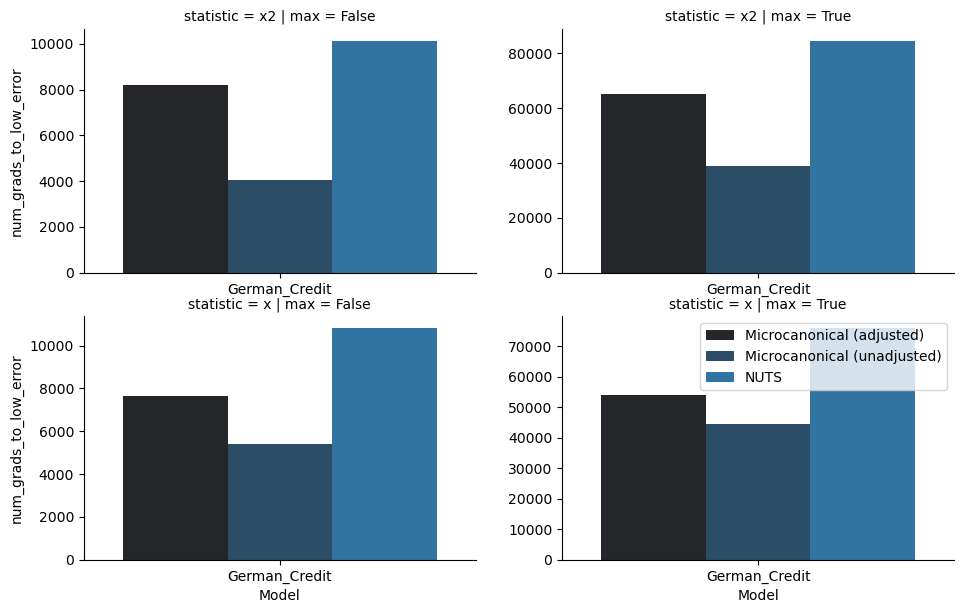

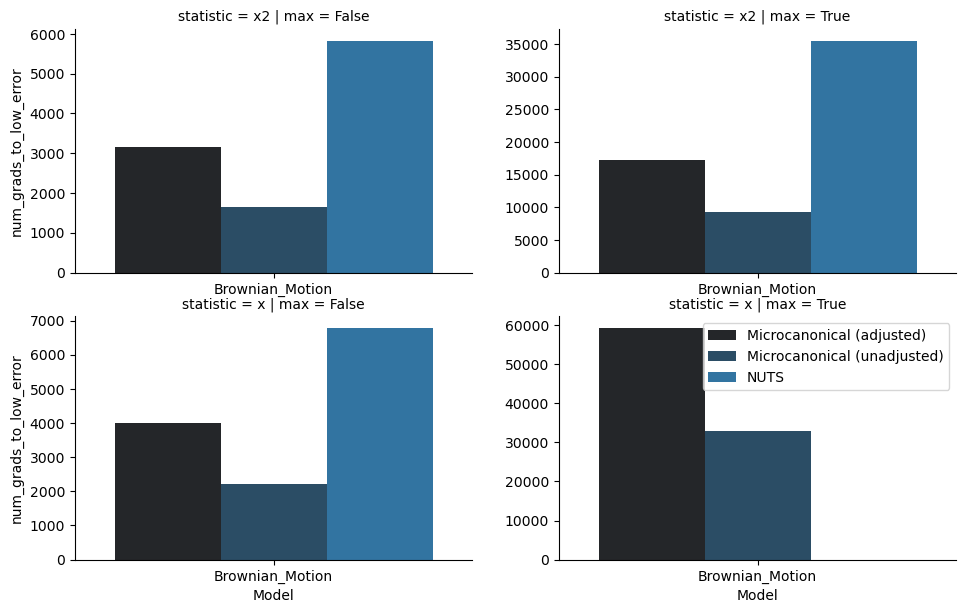

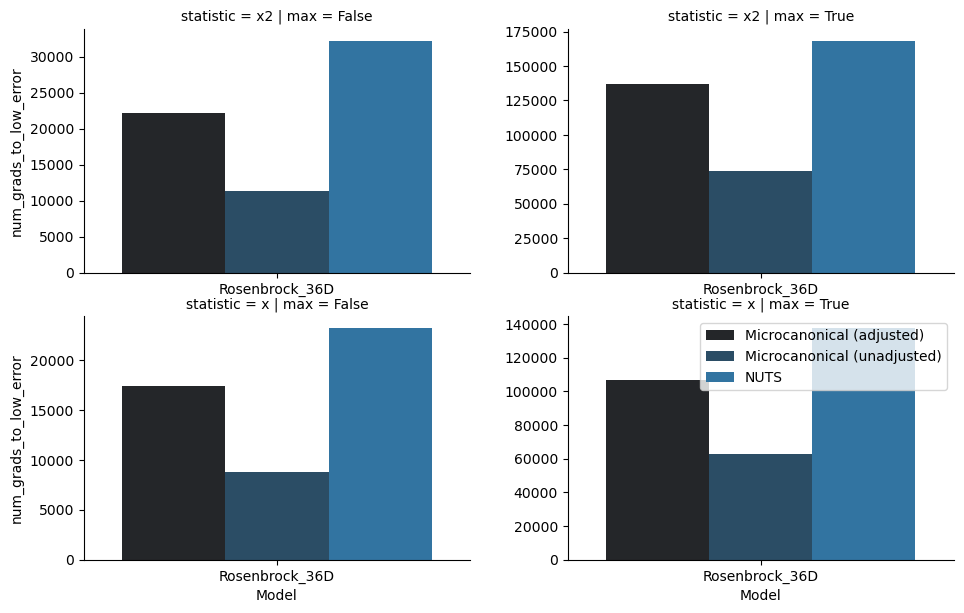

In [13]:
import numpy as np


def display_results(model_name,df, include_tuning=False):

  df["PrettyName"] = df["Sampler"].apply({"nuts": "NUTS", "unadjusted_microcanonical": "Microcanonical (unadjusted)", "adjusted_microcanonical": "Microcanonical (adjusted)"}.get)
  df["total_num_grads_to_low_error"] = df["num_grads_to_low_error"] + df["num_tuning_grads"]
  df = df[df["Model"] == model_name]

  g = sns.FacetGrid(df,
              col='max',
              row="statistic",
              sharex=False,
              sharey=False,
              height=4,
             )
  g = g.map(sns.barplot, 'Model',  'total_num_grads_to_low_error' if include_tuning else "num_grads_to_low_error", "PrettyName",  
            hue_order=np.unique(df["PrettyName"]), 
            order=np.unique(df["Model"]),
            # log_scale=True,
            palette='dark:#1f77b4'
  )
  plt.legend()
  plt.gcf().set_size_inches(10, 6)
  plt.show()

display_results("German_Credit", df, include_tuning=False)
display_results("Brownian_Motion", df, include_tuning=False)
# display_results("Neals_Funnel", df, include_tuning=False)
display_results("Rosenbrock_36D", df, include_tuning=False)
# display(df)